# Processing of OPERA Reduced GRACES Spectra

This Notebook performs some data reduction routines to convert the \*i.fits spectra from the Gemini Archive into a (hopefully) convenient and usable form for future science.

Everything is written for python 3.6

This version of the notebook was updated on May 4, 2020 for Fletcher Waller

If you have any questions, feel free to contact Collin Kielty at clkielty@uvic.ca


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# A thing for interactive plots
%matplotlib nbagg

import os
import sys
import csv

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.io import fits


# ---------- Import our functions 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import asap_lib.spectra as sa


# Paths to Places

Most of these directories will be created automatically, though be sure the "path" and "spath" directories already exisit and that you have all of your \*i.fits spectra in "spath"

In [3]:
# Object Name 
ObjName = 'P002.2778+32.2590'

In [4]:
# Path to where the "raw" \*i.fits files are stored (BE SURE THIS DIRECTORY ALREADY EXISTS AND HAS DATA IN IT)
spath = path + 'i_fits/' + ObjName + '/'

# Paths to the various sub-directories where intermediate spectra are stored
opath = path + 'standardize_OPERA/all_o/' + ObjName + '/' #All files with echelle order cut perfomed
tpath = path + 'standardize_OPERA/all_t/' + ObjName + '/' #All trimmed files
ipath = path + 'standardize_OPERA/all_i/' + ObjName + '/' #All interpolated files
rvpath = path + 'standardize_OPERA/all_rv/' + ObjName + '/' #All RV corrected files
# Path to where the final, fully reduced spectra will be stored
cpath = path + 'standardize_OPERA/combined/' + ObjName + '/' #All combined files (Pristine names)
# Path to a place to save any diagnostic output plots (if you choose to save them)
plotpath = path + 'standardize_OPERA/Plots/'+ ObjName + '/' #Path to output plots

NameError: name 'path' is not defined

In [5]:
# Check if these intermediate/final directories exist, and if not, create them
opath_folder= path + 'standardize_OPERA/all_o/'
tpath_folder= path + 'standardize_OPERA/all_t/'
ipath_folder= path + 'standardize_OPERA/all_i/'
rvpath_folder= path + 'standardize_OPERA/all_rv/'
cpath_folder = path + 'standardize_OPERA/combined/'
plotpath_folder = path + 'standardize_OPERA/Plots/'


list_o_paths_folder = [opath_folder, tpath_folder, ipath_folder, rvpath_folder, cpath_folder, plotpath_folder]


for p in list_o_paths_folder:
    
    exists = os.path.isdir(p)
    if not exists:
        print('Creating path: %s' % p)
        os.mkdir(p)
        
        
RVpath = path + 'standardize_OPERA/Measured_RVs/'
fileObjsNames = path + 'standardize_OPERA/file_object_names/'
# Check if these intermediate/final directories exist, and if not, create them
list_o_paths = [opath, tpath, ipath, rvpath, cpath, plotpath, RVpath, fileObjsNames]

for p in list_o_paths:
    
    exists = os.path.isdir(p)
    if not exists:
        print('Creating path: %s' % p)
        os.mkdir(p)

# Find the object name which corresponds to the observation ID

In [6]:
#Collect all spectra ID's from the i.fits file headers
all_files = os.listdir(spath)

names = []
files = []
useables = []

for file in all_files:
    
    if file.endswith('.fits'):
        
        # Read in the FITS spectrum
        data = fits.open(spath + file)
        
        # Collect the object name from the header
        name = data[0].header['OBJECT']
        
        # Save the file name, object name, and some information about the Gemini data quality assessment
        files.append(file)
        names.append(name)
        useables.append(data[0].header['RAWGEMQA']) 

print(files)
print(names)

# Most spectra are good (i.e. 'USABLE') but sometimes you will get an 'UNKNOWN' or something else. 
# If that is the case, proceed with caution on those spectra
print(useables)

['N20200923G0044i.fits', 'N20200923G0043i.fits', 'N20200923G0042i.fits']
['P002.2778+32.2590', 'P002.2778+32.2590', 'P002.2778+32.2590']
['UNKNOWN', 'USABLE', 'USABLE']


# Correct order overlap

Each i.fits spectrum contains a 1D wavelength calibrated, sky subtracted spectrum, however the spectrum is stitched together such that the spectral regions shared by echelle orders are overlapping (i.e. there are places in the spectrum with two sets of similar data: the red end of echelle order N and the blue end of echelle order N + 1).

"order_cut" identifies where the spectral arrays 'double back" (i.e. where we jump from the red end of echelle order N to the blue end of echelle order N + 1) and combines those two regions via a weighted average using the i.fits "error spectrum" to assign the weights.

This increases the SNR in those regions and makes the spectral arrays all nice and linear.

Input are:

"files" - A list or array of files to examine

"spath" - Path to the directory containing said files

"opath" - Path to the directory where the corrected spectra should be saved

All output spectra are saved as binary files for quick access.

In [7]:
spectra = files

for s in spectra:
    print(os.path.join(spath,s))

/arc5/home/jglover/Data/i_fits/P002.2778+32.2590/N20200923G0044i.fits
/arc5/home/jglover/Data/i_fits/P002.2778+32.2590/N20200923G0043i.fits
/arc5/home/jglover/Data/i_fits/P002.2778+32.2590/N20200923G0042i.fits


In [8]:
sa.order_cut(files, spath = spath, opath = opath, save = True, save_locs=True)

Saving order corrected spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_o/P002.2778+32.2590/N20200923G0044.o.bin
Saving order corrected spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_o/P002.2778+32.2590/N20200923G0043.o.bin
Saving order corrected spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_o/P002.2778+32.2590/N20200923G0042.o.bin
Saving locations of order overlaps to asap_lib/src/Standards_Olap_Info.npy


# Call "spec_ex" to examine each spectrum

Extract starting and ending wavelengths, number of points in the spectrum, and the mean pixel spacing in angstroms.

The purpose here is to put all the spectra onto the same grid/wavelength coverage

In [9]:
# Collect all of the order corrected spectra

all_o = os.listdir(opath)

objs_o = []
for o in all_o:
    if o.endswith('o.bin'):
        objs_o.append(o)
        
objs_o

['N20200923G0044.o.bin', 'N20200923G0042.o.bin', 'N20200923G0043.o.bin']

<IPython.core.display.Javascript object>


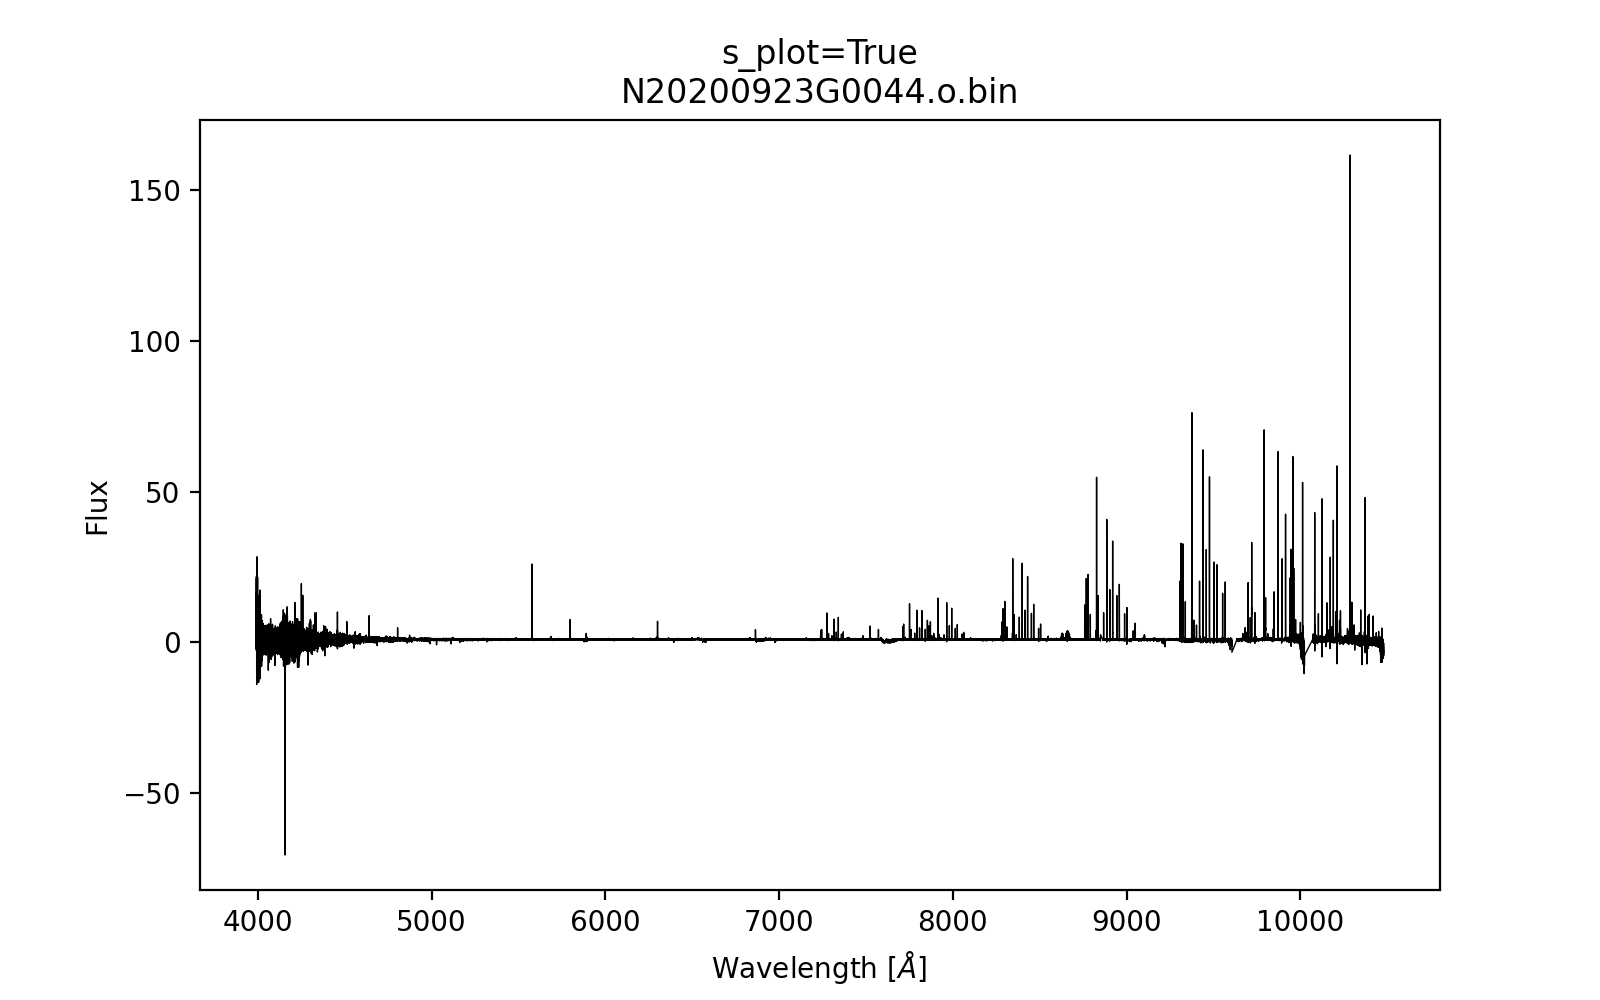

<IPython.core.display.Javascript object>


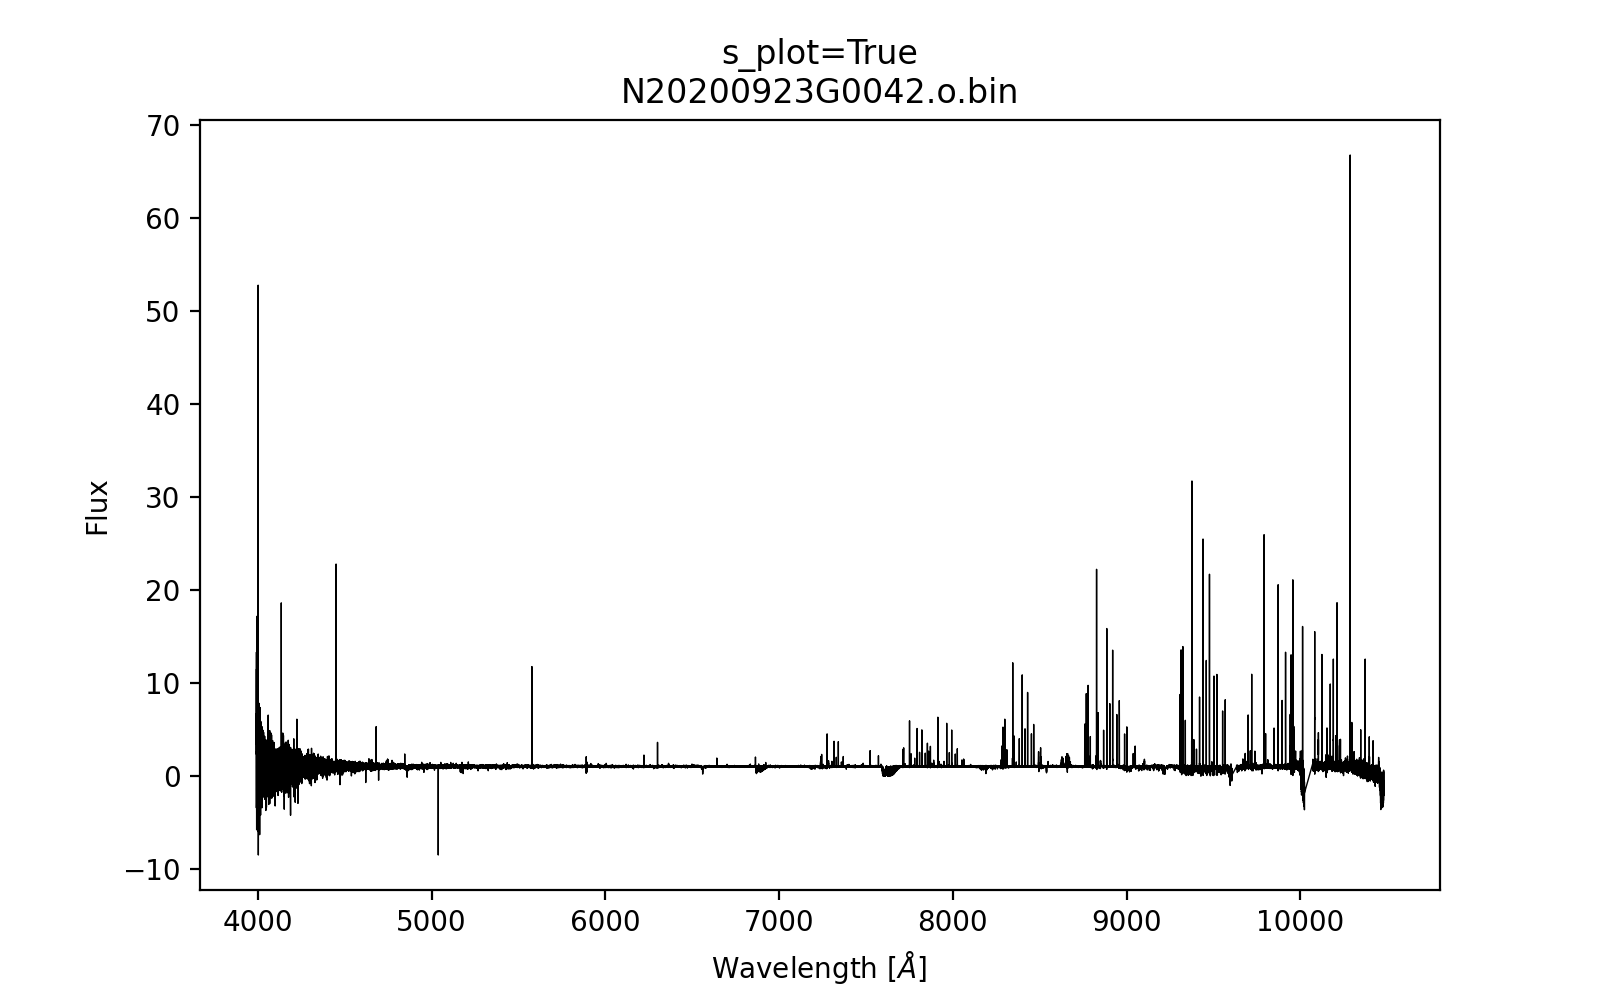

<IPython.core.display.Javascript object>


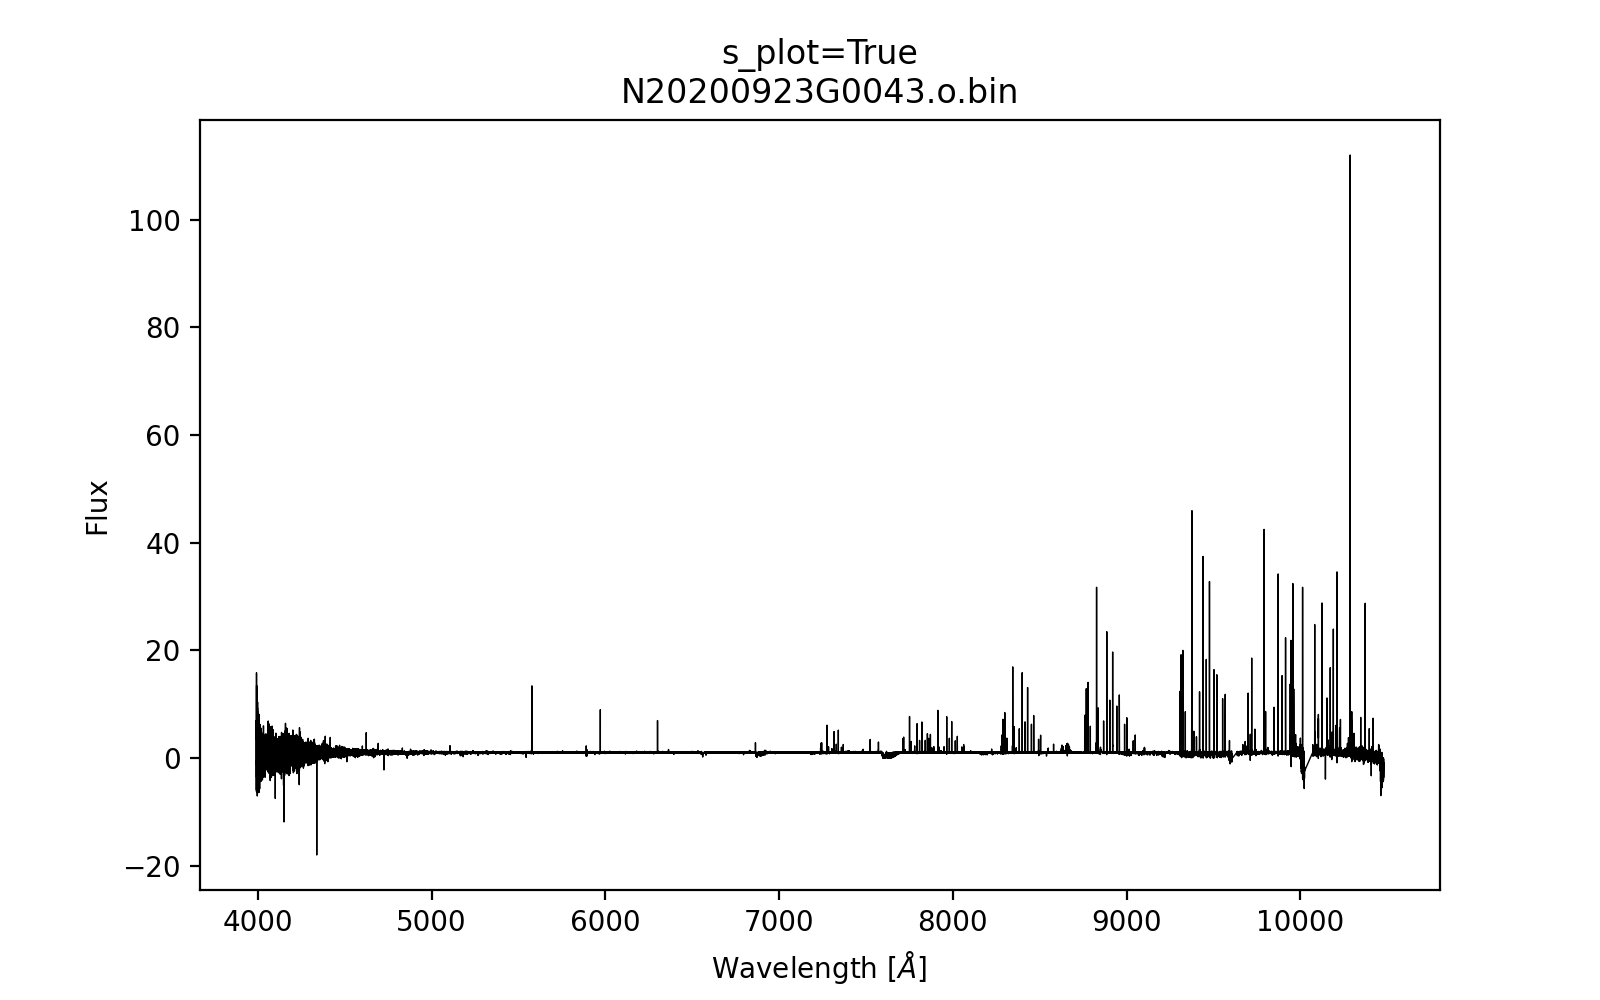

Shortest ending wavelength 3991.655517578125
Longest staring wavelength 10479.388671875
Mean number of points in all of the spectra 158652.33333333334
Standard deviation of the number of points in all of the spectra 0.4714045207910317
Mean pixel sampling in all of the spectra 0.040893


In [10]:
s = sa.spec_ex(spectra=objs_o, spath=opath, s_info=True, s_plot=True)

# # Save this output so you don't need to run spec_ex every time
np.save(os.path.join( os.getcwd(), 'GRACES_Spec_Info'), s)

s = np.load(os.path.join( os.getcwd(), 'GRACES_Spec_Info.npy'), allow_pickle=True)

#Make some arrays for min wavelength, max wave, N points, and mean pixel separation in angstroms (resolution)
mins = s[:,1,1]
maxs = s[:,2,1]
Ns = s[:,3,1]
means = s[:,4,1]

# We will see that not all of the spectra start/end at the same place, 
# nor do they have the same number of data points, or sampling.
# We want the data range that ALL of the spectra fit within
print('Shortest ending wavelength {}'.format(mins.max()))    
print('Longest staring wavelength {}'.format(maxs.min()))    
print('Mean number of points in all of the spectra {}'.format(Ns.mean()))     
print('Standard deviation of the number of points in all of the spectra {}'.format(Ns.std()))      
print('Mean pixel sampling in all of the spectra {}'.format(means.mean()))  

# Trim all of the spectra to the same wavelength coverage

In [11]:
#Define the new wavelength range (a buffer of 10A is removed on both ends)

wavelims = [round(mins.max() + 10), round(maxs.min() - 10.)]

# All spectra reduced by this notebook, for this particular data set will span the following wavelengths (A)

print(wavelims)

[4002, 10469]


In [12]:
# Collect all of the order corrected spectra (again, in case you are not running things in order)
all_o = os.listdir(opath)

objs_o = []
for o in all_o:
    if o.endswith('o.bin'):
        objs_o.append(o)
        
#Trim all of the spectra to the same wavelength coverage by calling spec_trim. 
#This will output binary ".trim" files into tpath
new_wave = sa.spec_trim(spectra=objs_o, spath=opath, xlims = wavelims, new_wave=True, save = True, tpath = tpath)

# Some print statements as a sanity check (make sure the values below agree with the printed values above)
print('\n')
print('New number of points in the spectra {}'.format(len(new_wave)) )                                      
print('New starting wavelength {}'.format(np.min(new_wave)) )                                   
print('New ending wavelength {}'.format(np.max(new_wave)) )                                   
print('New pixel sampling {}'.format((np.max(new_wave) - np.min(new_wave))/len(new_wave))) 

Saving trimmed spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_t/P002.2778+32.2590/N20200923G0044.o.trim.bin
Saving trimmed spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_t/P002.2778+32.2590/N20200923G0042.o.trim.bin
Saving trimmed spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_t/P002.2778+32.2590/N20200923G0043.o.trim.bin


New number of points in the spectra 158059
New starting wavelength 4002.0
New ending wavelength 10469.0
New pixel sampling 0.04091510132292372


# Interpolate the spectra onto the same grid

Though the spectra have the same starting and ending wavelengths, pixel 124 in spectrum 1 might not correspond to the exact same wavelength as pixel 124 in spectrum 2. We need to interpolate all spectra onto the same pixel grid for radial velocity correction and stacking of visits

In [13]:
# Collect all of the order corrected and trimmed spectra
all_o = os.listdir(tpath)
objs_t = []
for o in all_o:
    if o.endswith('trim.bin'):
        objs_t.append(o)
objs_t

['N20200923G0043.o.trim.bin',
 'N20200923G0042.o.trim.bin',
 'N20200923G0044.o.trim.bin']

In [14]:
# Interpolate all the spectra onto the same grid ("new_wave" from above)
sa.spec_interp(spectra=objs_t, spath=tpath, i_wave = new_wave, save = True, ipath = ipath)

Saving interpolated spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_i/P002.2778+32.2590/N20200923G0043.o.trim.i.bin
Saving interpolated spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_i/P002.2778+32.2590/N20200923G0042.o.trim.i.bin
Saving interpolated spectrum to /arc5/home/jglover/Data/standardize_OPERA/all_i/P002.2778+32.2590/N20200923G0044.o.trim.i.bin


In [15]:
# Collect all of the order corrected, trimmed and interpolated spectra
all_o = os.listdir(ipath)
objs_i = []
for o in all_o:
    if o.endswith('i.bin'):
        objs_i.append(o)
objs_i

['N20200923G0042.o.trim.i.bin',
 'N20200923G0043.o.trim.i.bin',
 'N20200923G0044.o.trim.i.bin']

In [16]:
# Make sure that all is right and well and that the interpolated spectra have the same start/end/sampling
s = sa.spec_ex(spectra=objs_i, spath=ipath, s_info=True)

# #Make some arrays for min wavelength, max wave, N points, and mean pixel separation in angstroms (resolution)
mins = s[:,1,1]
maxs = s[:,2,1]
Ns = s[:,3,1]
means = s[:,4,1]

# If the minimum and maximum value of the various metrics below are equal, 
# then we know the spectra are finally all on the same grid
print('Mins: ', np.min(mins), np.max(mins))            # Min and max staring wavelength should be the same
print('Maxs: ', np.min(maxs), np.max(maxs))            # ''' ending wavelength '''
print('Lengths: ', np.min(Ns), np.max(Ns))             # ''' number of points '''
print('Dispersions: ', np.min(means), np.max(means))   # ''' sampling '''

Mins:  4002.0 4002.0
Maxs:  10469.0 10469.0
Lengths:  158059 158059
Dispersions:  0.040915 0.040915


# Combine the indiviudal visit spectra

Most of the data we collect will have multiple visit spectra for an individual star. Here we will combine those visits into a single high SNR spectrum.

This portion has been adopted from a script by Stephanie Monty

In [17]:
# Collect all spectra ID's from the i.fits files
# We have done this before, but it doesn't hurt to do it again (especially if you are starting here)

all_files = os.listdir(spath)

files = []
names = []

for file in all_files:
    
    if file.endswith('.fits'):
        
        data = fits.open(spath + file)
        
        name = data[0].header['OBJECT']
        
        # While we are looking at the i.fits files here, we will be processing the .o.trim.i.bin 
        # files later so let's save those
        
        split = file.split('i.fits') # Split off just the file name
        fname = split[0]
        reduced_fname = fname + '.o.trim.i.bin' # Add on the reduced spectrum file extension
        
        files.append(reduced_fname)
        
        names.append(name)

print(names)
print(files)

['P002.2778+32.2590', 'P002.2778+32.2590', 'P002.2778+32.2590']
['N20200923G0044.o.trim.i.bin', 'N20200923G0043.o.trim.i.bin', 'N20200923G0042.o.trim.i.bin']


In [18]:
# If all looks good above, save the object names and file names for future reference
print('Saving files to' +fileObjsNames+ObjName+'.txt')
ascii.write([files,names],fileObjsNames+ObjName+'.txt',overwrite=True)

Saving files to/arc5/home/jglover/Data/standardize_OPERA/file_object_names/P002.2778+32.2590.txt


In [19]:
# This section loads the specified list into lists of object names and file names.

obj_list = fileObjsNames+ObjName+'.txt'

objects = []
file_names = []
dict_file_obj = {}

with open(obj_list, 'r+') as tsvin:
    info = csv.reader(tsvin, delimiter="\t")
    
    # Separate the information in the csv object into "rows" or lists of strings
    for row in info:
        
        # Don't save the header information from the object list
        if row[0].startswith('#'):
            pass

        # Don't save the header information from the object list        
        if row[0].startswith('col'):
            pass
        
        # Split the list of strings into two groups (file name, object name) using a space character as the delim.
        else:
            split = row[0].split(' ')
            
            file_name = split[0]
            
            if len(split) == 2:
                obj_name = split[1]
            
            if len(split) == 3:
                obj_name = split[1].strip('\"') + ' ' + split[2].strip('\"')
            
            dict_file_obj[ipath+file_name] = obj_name # Maps object name to filename
            file_names.append(ipath+file_name) # Just the raw file names
            objects.append(obj_name) # Just the object names

# A usable dictionary of object names and file names
dict_file_obj

{'/arc5/home/jglover/Data/standardize_OPERA/all_i/P002.2778+32.2590/N20200923G0044.o.trim.i.bin': 'P002.2778+32.2590',
 '/arc5/home/jglover/Data/standardize_OPERA/all_i/P002.2778+32.2590/N20200923G0043.o.trim.i.bin': 'P002.2778+32.2590',
 '/arc5/home/jglover/Data/standardize_OPERA/all_i/P002.2778+32.2590/N20200923G0042.o.trim.i.bin': 'P002.2778+32.2590'}

In [20]:
"""
This section searches through the list of object names for repeated entries and stacks the corresponding files.
It pulls the corresponding files using the indices (as objects and file_names were generated from the same file).
"""
# A variable to deal with querying for the same entry twice, leads to querying the list_duplicates_of function only
#once for multiple instances of the same object name.
name_loc = {}

# Find the indices associated with each object name
for name in objects:
    locs = sa.list_duplicates_of(objects, name)
    
    # Store the indices where each object occurs using the object name
    name_loc[name] = locs

## Plot all of the visits for a particular object on top of one another to look for RV variations in the visits

This script does not currently correct for visit RV's as my programs have never had any, but if you do see RV varations, contact Kim and/or Collin for further discussion

<IPython.core.display.Javascript object>


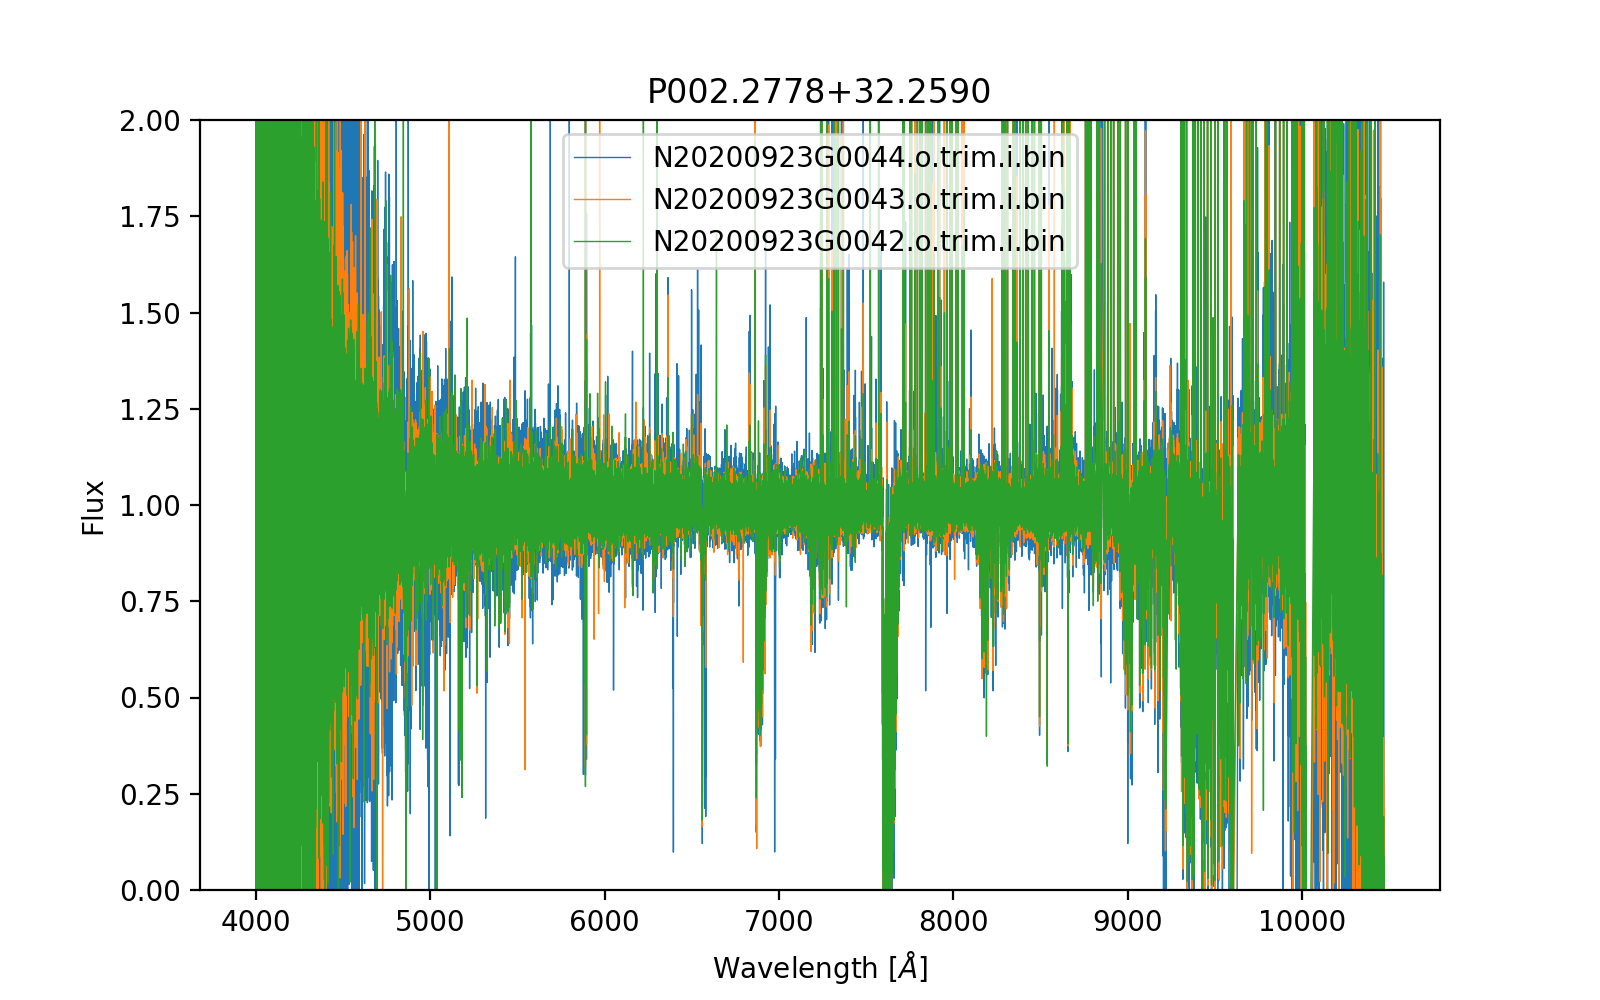

In [21]:
obj_names = name_loc.keys()

for oname in obj_names:
    inds = name_loc[oname]
    visits = np.asarray(files)[inds]
    
    plt.figure(figsize=(8,5))
    
    for v in visits:
        
        wave, flux, err = sa.read_spec(os.path.join(ipath,v), ftype='bin')
        
        plt.plot(wave, flux, label = v,linewidth=0.5)
        
    plt.title(oname)
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Flux')
    plt.legend()
    plt.ylim(0., 2.)

## JG: Take a closer look at some spectral lines 
- More useful than plotting the entire spectra to look for radial velocity variations 

Ha


<IPython.core.display.Javascript object>


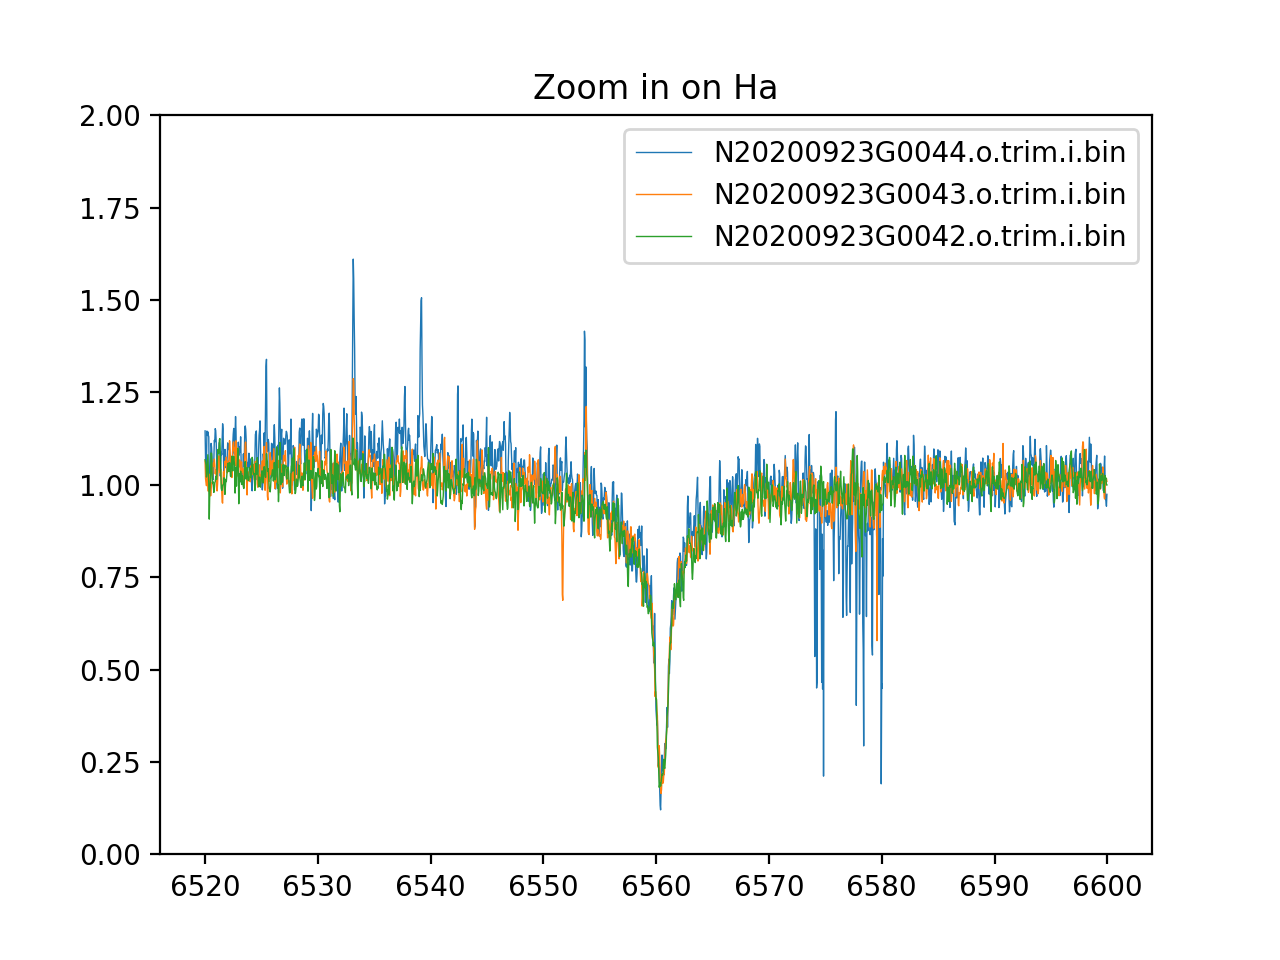

Hb


<IPython.core.display.Javascript object>


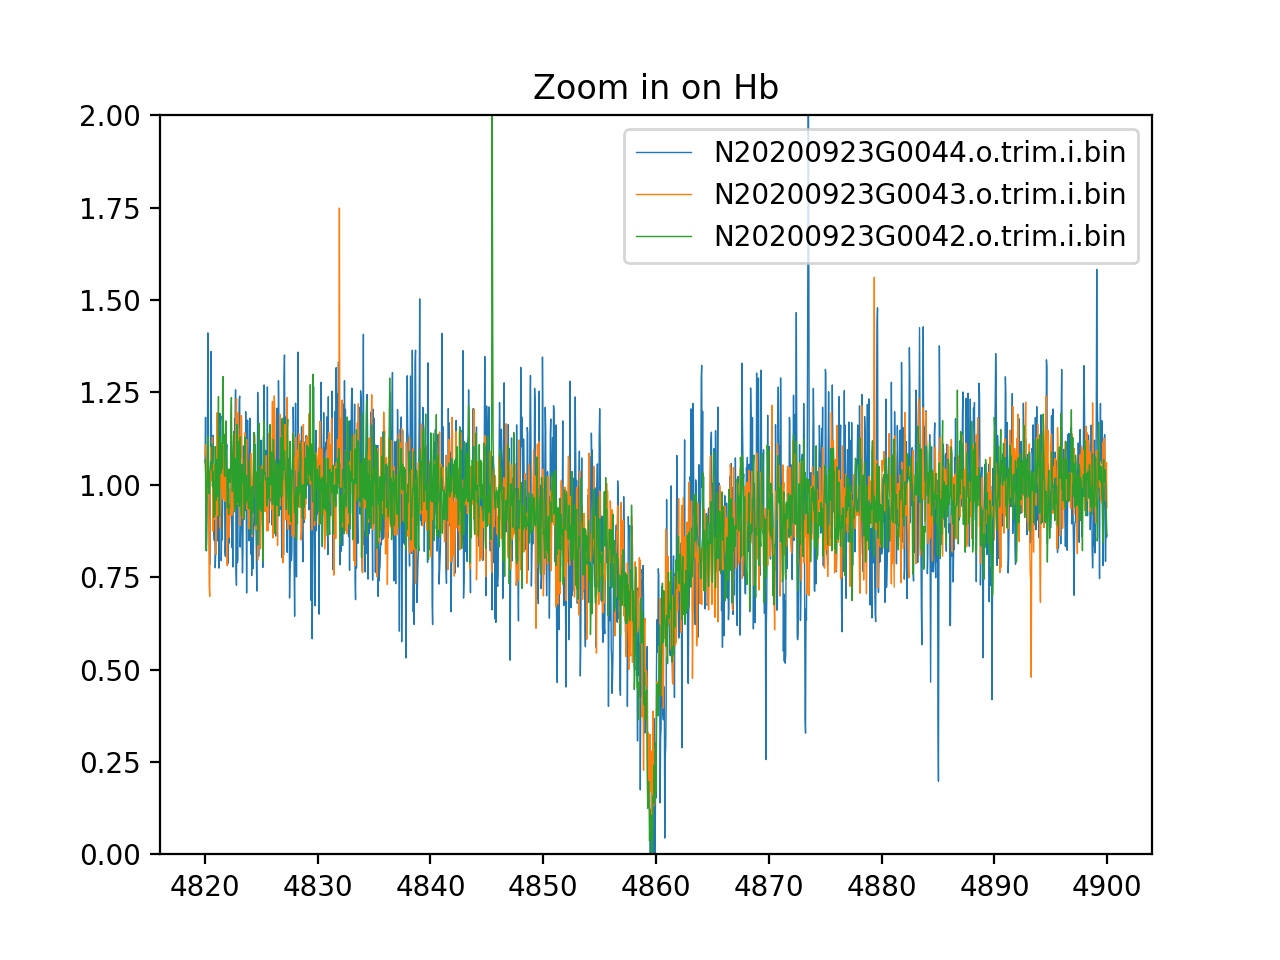

Mg


<IPython.core.display.Javascript object>


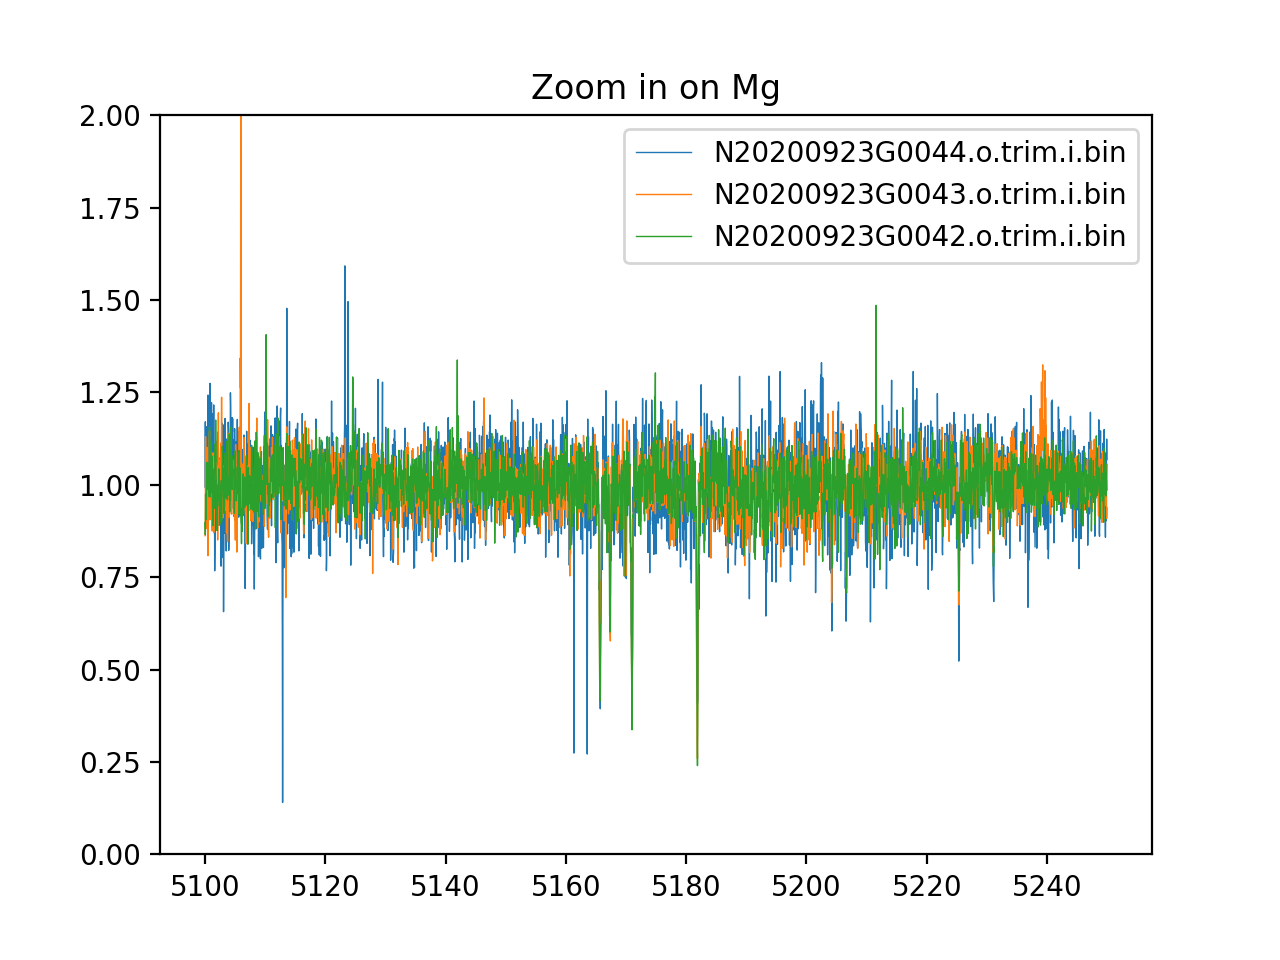

Na


<IPython.core.display.Javascript object>


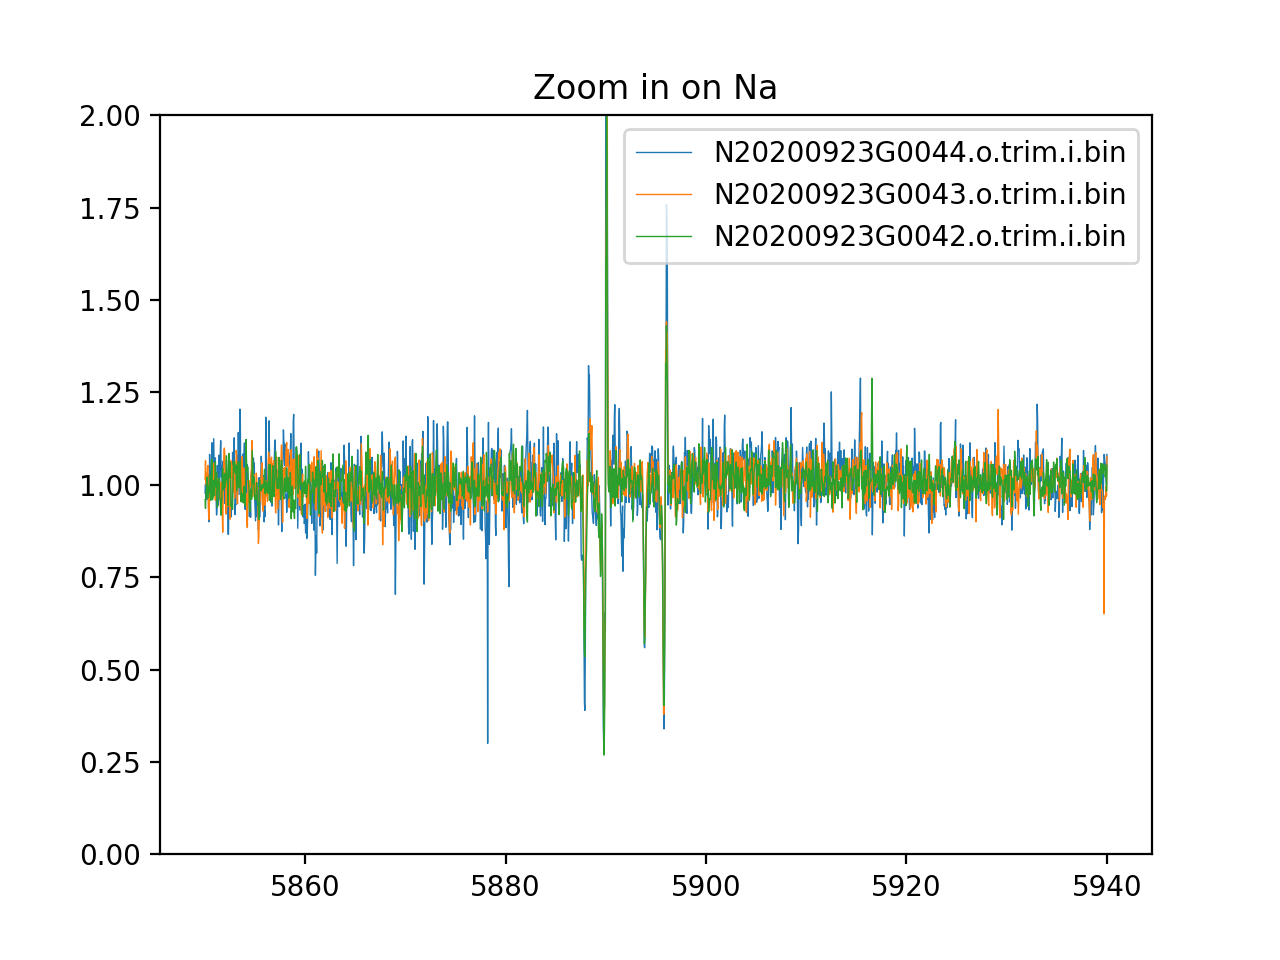

In [22]:
elems = ['Ha','Hb', 'Mg', 'Na'] 

for e in elems:
    print(e)
    
    plt.figure()

    for v in visits:
        wave, flux, err = sa.read_spec(os.path.join(ipath,v), ftype='bin')
        chopd_wave, chopd_flux = sa.spec_chop(wave, flux,[e])
        plt.plot(chopd_wave[0], chopd_flux[0], label = v,linewidth=0.5)

    plt.title('Zoom in on '+e)
    plt.legend()
    plt.ylim(0., 2.)

## Stack the visit spectra


JG:
- This is the code that does the actual "combining" of the visit spectra

- Above we just collected the visit spectra for each object 

In [23]:
#Save the instances where the objects occured more than once, these are the spectra to stack

for name in name_loc.keys():
    
    # Visits of name
    occurs = name_loc[name]
    
    sa.spec_stack(spectra = files, name = name, occurs = occurs, spath = ipath, combpath = cpath, 
               print_prog = True)

Object:  P002.2778+32.2590  - Handling file  N20200923G0044.o.trim.i.bin  ( 1 of 3 )
Object:  P002.2778+32.2590  - Handling file  N20200923G0043.o.trim.i.bin  ( 2 of 3 )
Object:  P002.2778+32.2590  - Handling file  N20200923G0042.o.trim.i.bin  ( 3 of 3 )
Saving combined spectrum to /arc5/home/jglover/Data/standardize_OPERA/combined/P002.2778+32.2590/P002.2778+32.2590.comb.bin


# RV Correction

Correct the spectra for radial velocity variations using a template spectrum as a reference

In [24]:
#Compile all the order corrected, trimmed, interpolated, and combined spectra 
all_c = os.listdir(cpath) 

c_files = []
c_names = []

for o in all_c:
    
    if o.endswith('.comb.bin'):
        
        # Combined file names
        c_files.append(o)
        
        split = o.split('.comb.bin')
        
        c_names.append(split[0])
        
print(c_files)
print('')
print(c_names)

['P002.2778+32.2590.comb.bin']

['P002.2778+32.2590']


## rvcorr



rvcor is a beast of a function and I feel sorry for whoever has to update it with new methods (likely will be me anyway). Below is a list of the various input and features:

Input:
* List or array of all of the files
* Path to where these files are found
* Name of the template spectrum
* Path to where the template is found
* Names of the objects we are looking at

* elems = ['Ha', 'Hb', 'Mg', 'Na'] or elems = 'all' - which windows to look at for the template cross correlation
    * I recommend only using **['Ha', 'Hb', 'Mg']** as these are usually the "cleanes" windows.
    * If you are finding a lot of RV variation between these windows, try the others or contact Collin
* manual_rv = A way to specify a user input RV but I don't remember how to do this at the moment
    * I'd stick with **manual_rv = None** unless you are really having issues
* save_out_spec = **True**/False (you generally will want to save the output spectrum)
* out_path = where to save the output spectrum to
* plot_synth = True/**False** - do you want to plot the whole template spectrum?
* plot_obs = True/**False** - do you want to plot the whole observed spectrum?
* plot_regions = True/**False** - do you want to plot the windows you identified with "elems"?
* plot_shift = True/**False** - do you want to plot the shifted spectrum in each window?
* plot_corr = **True**/False - do you want to plot the full final corrected spectrum?
* print_spec_info = True/**False** - do you want to plot information about the spectrum (sampling and whatnot)?
* print_rv_info = **True**/False - do you want to plot information about the wavelength correction?
    * Generally I do to make sure each window is giving me roughly the same RV
* save_rv_info = **True**/False - do you want to save the RV's for later reference?
* rv_save_name = Name of the file you want the RV's saved into
* plot_corr_spec_info = True/**False** - do you want to print information about the new spectrum?
* save_plot = True/**False** - do you want to save all plots created?
* save_plot_path = Path to where you might want to save plots to
* pause = True/**False** - do you want the script to pause between files?

## How Collin usually does this:
On first pass, I'll usually use:

* elems = ['Ha', 'Hb', 'Mg', 'Na']
* manual_rv = None
* save_out_spec = False
* plot_synth = False
* plot_obs = False
* plot_regions = True
* plot_shift = False
* plot_corr = True
* print_spec_info = False
* print_rv_info = True
* save_rv_info = False
* plot_corr_spec_info = False
* save_plot = False
* pause = False

to make sure the windows I chose are okay and that the initail RV's are all looking good. I'll remove bad windows that gave wonly RV's. I don't save anything at this time as I might make changes later.

If everything looks fine, then I'll re-run the cell with:
* elems = *whatever I decided is good*
* manual_rv = None
* save_out_spec = True
* plot_synth = False
* plot_obs = False
* plot_regions = False
* plot_shift = False
* plot_corr = True
* print_spec_info = False
* print_rv_info = True
* save_rv_info = True
* plot_corr_spec_info = False
* save_plot = False
* pause = False

If some regions are bad for some stars and good for others, you may need to run your stars in little batches, varying which windows and RV's you use.

You also might get an error saying something like "ValueError: cannot reshape array of size 0 into shape (0,newaxis)". This usually means the element window you are looking at is outside of the spectral coverage of your template spectrum. plot_synth = True can help identify this.

# IMPORTANT: THE RV's SAVED IN THE OUTPUT FILE ARE THE **APPLIED** RV CORRECTION. THIS MEANS THE RV OF THE STAR IS -1\*THIS VALUE

I.e. if the RV is given as -11.2 +/- 2.3 km/s then the RV we would report is 11.2 +/- 2.3 km/s


## JG: ^ I am not too sure about that - maybe it was fixed but the comment wasn't taken out 

- Positive radial velocity means moving away and negative radial velocity means moving towards
- If the observed spectral lines occur at a shorter wavelength (before) the template spectrum then that means the object is moving towards and if the spectral lines are at a longer wavelength (after) that means the object is moving away  

- I also think the print statements should say "velocity correction from __ lines: "

In [26]:
#Check the RV corrected spectra to make sure we didn't mess anything up with the interpolations 
alls = os.listdir(cpath)
objs_rv = []
for f in alls:
    if f.endswith('.comb.rv.bin'):
        objs_rv.append(f) 
objs_rv

['P002.2778+32.2590.comb.rv.bin']

In [27]:
s = sa.spec_ex(spectra=objs_rv, spath=cpath, s_info=True)

# #Make some arrays for min wavelength, max wave, N points, and mean pixel separation in angstroms (resolution)
mins = s[:,1,1]
maxs = s[:,2,1]
Ns = s[:,3,1]
means = s[:,4,1]

print('Mins: ', np.min(mins), np.max(mins))
print('Maxs: ', np.min(maxs), np.max(maxs))
print('Lengths: ', np.min(Ns), np.max(Ns))
print('Dispersions: ', np.min(means), np.max(means))

Mins:  4002.0 4002.0
Maxs:  10469.0 10469.0
Lengths:  158059 158059
Dispersions:  0.040915 0.040915


# Normalization
While the OPERA spectra come continuum normalized, they are not perfect. In this final step, we will perform an asymmetric sigma clipping routine to further flatten the spectra

<IPython.core.display.Javascript object>


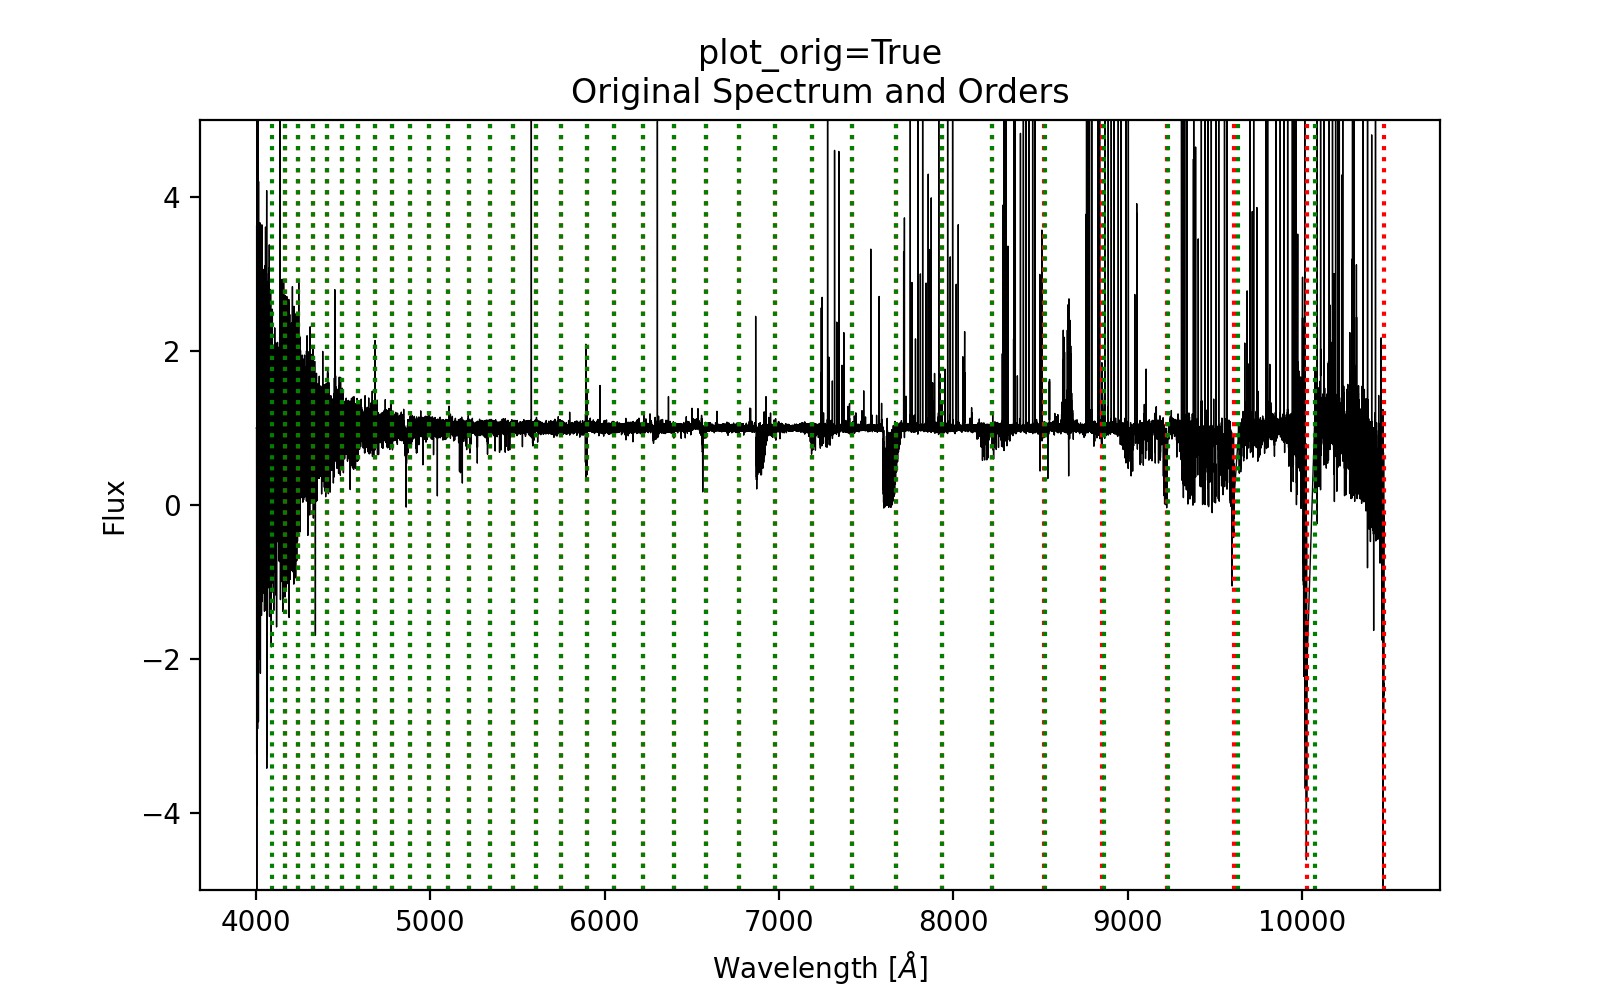

<IPython.core.display.Javascript object>


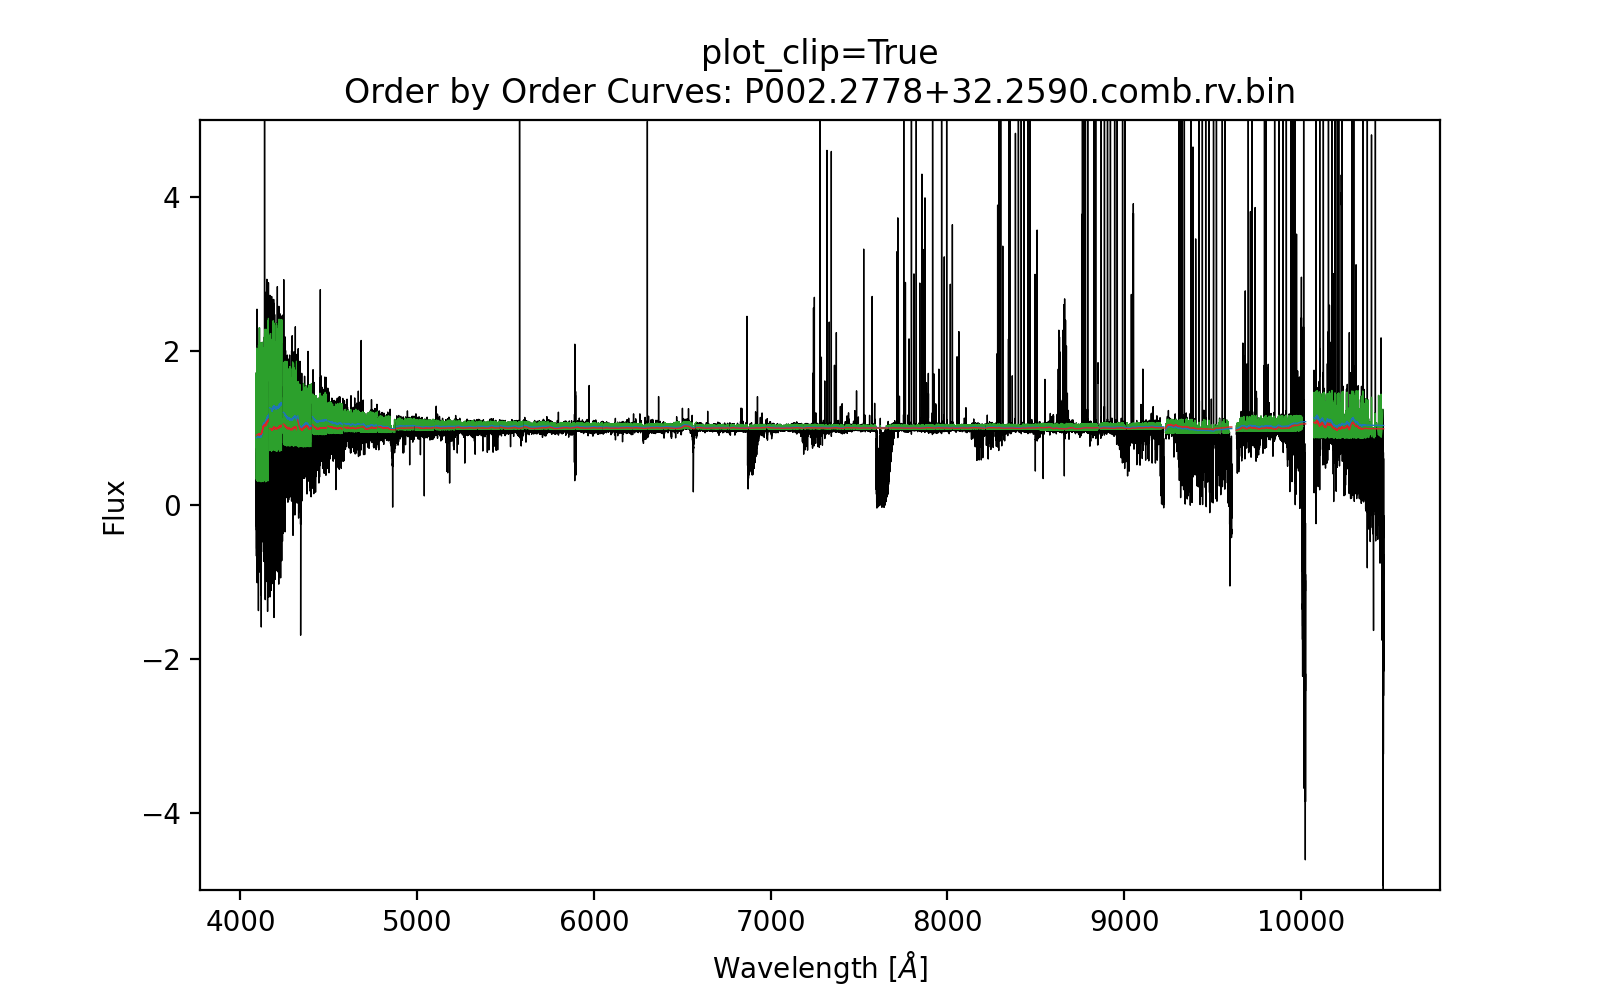

<IPython.core.display.Javascript object>


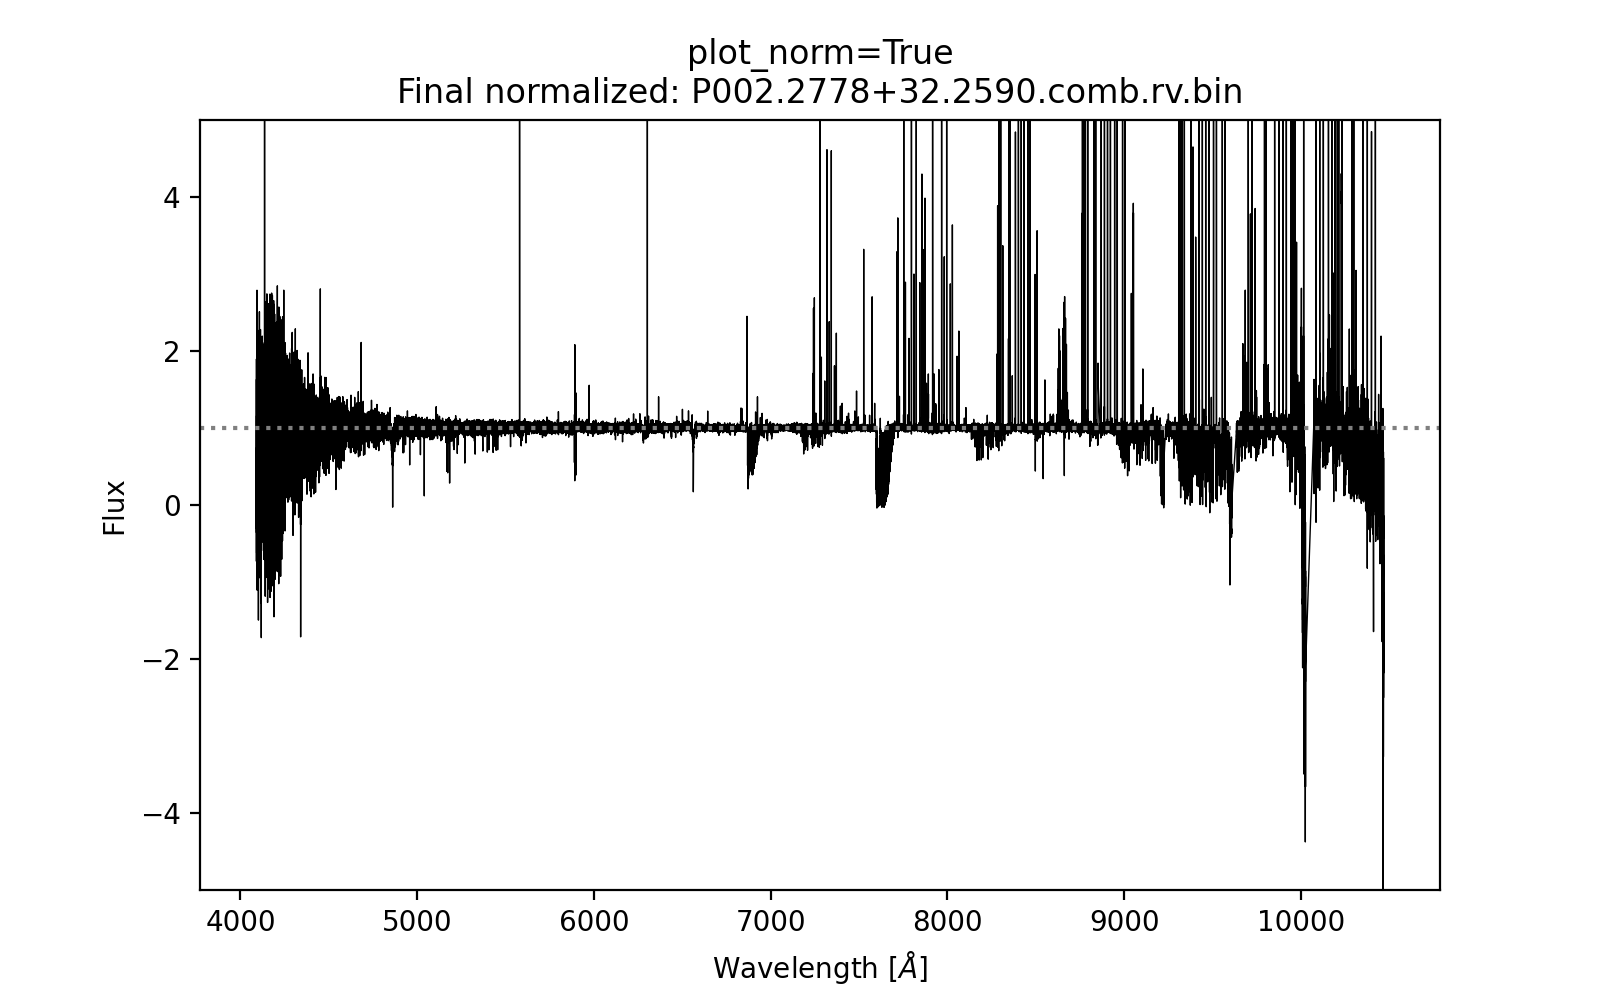

In [28]:
sa.spec_norm(objs_rv, cpath, 
              os.path.join(os.getcwd(), 'asap_lib/src/Standards_Olap_Info.npy'), 
              [1.5,3], 
            301,
             1, 
             1.0,
              plot_orig = True,
              plot_clip = True, 
              plot_norm = True, 
              save_norm = True,
              out_path = cpath)

# That's it! The two routines below convert the final order corrected, trimmed, interpolated, combined, RV corrected, and continuum normalized spectra into slighlty more useful forms for MOOG

If you need to recreate some FITS files, let us know and we can figure that one out

# Create .xy spectra
Create some ascii xy spectra (wavelength flux) for MOOG

In [29]:
objs = []
objs_paths = []
for root, dirs, files in os.walk(cpath):
    for file in files:
        if file.endswith('norm.bin'):
            objs.append(file)
            objs_paths.append(root)
            
print(objs)
print(objs_paths)

# Create a place for the final spectra
final_path = path + 'final_spectra/' 

exists = os.path.isdir(final_path)

if not exists:
    print('Creating path: %s' % final_path)
    os.mkdir(final_path)
    
final_paths = [final_path] * len(objs)
final_paths

['P002.2778+32.2590.comb.rv.norm.bin']
['/arc5/home/jglover/Data/standardize_OPERA/combined/P002.2778+32.2590/']


['/arc5/home/jglover/Data/final_spectra/']

In [30]:
sa.bin2xy(objs, objs_paths, final_paths, xytype = 'MOOG')